## Goal:
- Create a regression model for predicting housing prices (column 'median_house_value').

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv')
len(df)

20640

In [6]:
df.head().T

0         1         2         3         4
longitude            -122.23   -122.22   -122.24   -122.25   -122.25
latitude               37.88     37.86     37.85     37.85     37.85
housing_median_age      41.0      21.0      52.0      52.0      52.0
total_rooms            880.0    7099.0    1467.0    1274.0    1627.0
total_bedrooms         129.0    1106.0     190.0     235.0     280.0
population             322.0    2401.0     496.0     558.0     565.0
households             126.0    1138.0     177.0     219.0     259.0
median_income         8.3252    8.3014    7.2574    5.6431    3.8462
median_house_value  452600.0  358500.0  352100.0  341300.0  342200.0
ocean_proximity     NEAR BAY  NEAR BAY  NEAR BAY  NEAR BAY  NEAR BAY

In [7]:
df.ocean_proximity.unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [9]:
df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]
len(df)

15687

In [10]:
df.isnull().any(axis=0)

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms         True
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
dtype: bool

In [11]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [12]:
df.total_bedrooms = df.total_bedrooms.fillna(0)

- Apply the log transform to `median_house_value`.
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the `train_test_split` function and set the `random_state` parameter to 1.

In [13]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

- We will use `DictVectorizer` to turn train and validation into matrices.

In [14]:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

In [15]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable.

- Train a model with `max_depth=1`.

Which feature is used for splitting the data?

- `ocean_proximity`
- `total_rooms`
- `latitude`
- `population`

In [16]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [17]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



## Question 2

Train a random forest model with these parameters:
- n_estimators=10
- random_state=1
- n_jobs=-1 (optional - to make training faster)

What's the RMSE of this model on validation?
- 0.045
- 0.245
- 0.545
- 0.845

In [18]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [19]:
y_pred = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

0.24491083521701304

## Question 3

Now let's experiment with the `n_estimators` parameter
- Try different values of this parameter from 10 to 200 with step 10.
- Set `random_state` to `1`.
- Evaluate the model on the validation dataset.

After which value of `n_estimators` does RMSE stop improving? Consider 3 decimal places for retrieving the answer.
- 10
- 25
- 50
- 160

In [20]:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

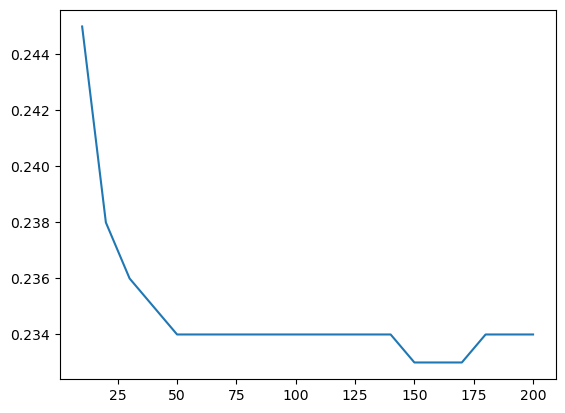

In [21]:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))
plt.show()

## Question 4

Let's select the best `max_depth`:
- Try different values of `max_depth`: `[10, 15, 20, 25]`
- For each of these values,
  - try different values of `n_estimators` from 10 till 200 (with step 10)
  - calculate the mean RMSE
- Fix the random seed: `random_state=1`

What's the best `max_depth`, using the mean RMSE?
- 10
- 15
- 20
- 25

In [23]:
scores = []

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(n_estimators=0,
                          max_depth=d,
                          random_state=1, n_jobs=-1,
                          warm_start=True)
    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))
        
        scores.append((d, n, score))

df_scores = pd.DataFrame(
    scores,
    columns=['max_depth', 'n_estimators', 'rmse'])

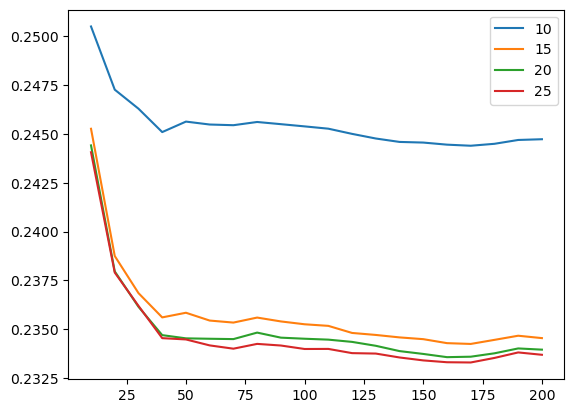

In [24]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()
plt.show()

## Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field.

For this homework question, we'll find the most important feature:
- Train the model with these parameters:
  - `n_estimators=10`,
  - `max_depth=20`,
  - `random_state=1`,
  - `n_jobs=-1` (optional)
- Get the feature importance information from this model

What's the most important feature (among these 4)?
- `total_rooms`
- `median_income`
- `total_bedrooms`
- `longitude`

In [25]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, 
                           random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [26]:
rf.feature_importances_

array([0.01446473, 0.03001848, 0.10249128, 0.08603838, 0.33554034,
       0.21881985, 0.14745955, 0.02827243, 0.01573663, 0.02115832])

In [27]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
df_importances

feature  importance
0                 households    0.014465
1         housing_median_age    0.030018
2                   latitude    0.102491
3                  longitude    0.086038
4              median_income    0.335540
5  ocean_proximity=<1H OCEAN    0.218820
6     ocean_proximity=INLAND    0.147460
7                 population    0.028272
8             total_bedrooms    0.015737
9                total_rooms    0.021158

In [28]:
df_importances.sort_values(by='importance', ascending=False).head()

feature  importance
4              median_income    0.335540
5  ocean_proximity=<1H OCEAN    0.218820
6     ocean_proximity=INLAND    0.147460
2                   latitude    0.102491
3                  longitude    0.086038

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:
- Install XGBoost.
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

```python
xgb_params = {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
```

In [30]:
import re

features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) 
        if any(x in str(col) 
           for x in set(('[', ']', '<'))) 
        else col 
    for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [31]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

In [32]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [38]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [39]:
scores['eta=0.3'] = parse_xgb_output(output)

In [40]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [41]:
scores['eta=0.1'] = parse_xgb_output(output)

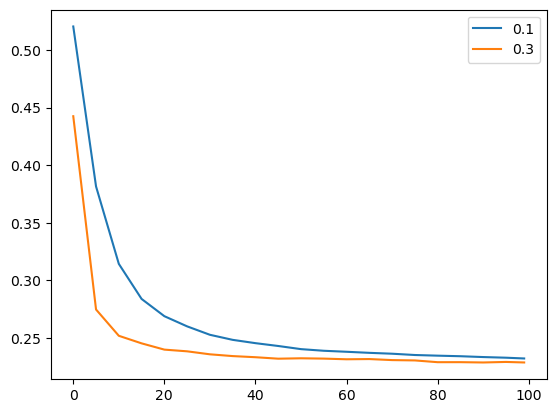

In [42]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc,
        label='0.3')
plt.legend()
plt.show()